In [2]:
!pip install ucimlrepo
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo
import pandas as pd

# fetch dataset
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)
df = diabetes_130_us_hospitals_for_years_1999_2008.data

# data (as pandas dataframes)
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets

##convert y to binary, YES if <30, NO for any other
y_binary = ['NO' if (x == 'NO' or x == '>30') else 'YES' for x in y['readmitted']]
##then do 0 for all NOs, 1 for all YES(<30)
y_encoded = LabelEncoder().fit_transform(y_binary)

##drop weight as it might skew with 98% gone
##drop tolazamide, miglitol, tolbutamide, glipizide-metformin
##troglitazone, acetohexamide, metformin-rosiglitazone,
##glimepiride-pioglitazone, metformin-pioglitazone, citoglipton
##examide as they showed up as super low feature importance
X = X.drop('weight', axis=1, errors='ignore')
columns_to_drop = [
    'tolazamide', 'miglitol', 'tolbutamide', 'glipizide-metformin',
    'troglitazone', 'acetohexamide', 'metformin-rosiglitazone',
    'glimepiride-pioglitazone', 'metformin-pioglitazone', 'citoglipton',
    'examide'
]

# Drop the columns
X = X.drop(columns=columns_to_drop, axis=1, errors='ignore')

##split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)



/usr/local/lib/python3.10/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


In [16]:
import numpy as np
##check y labels, 0 for NO,
print(np.unique(y_train))

[0 1]


In [3]:
def fit_label_encode(df_train):
    object_cols = df_train.select_dtypes(include=['object']).columns.tolist()
    encoders = {}  # To store LabelEncoders for each column

    for col in object_cols:
        le = LabelEncoder()
        # Handle unseen values by adding them to the encoder's classes_
        # This ensures all potential values are accounted for
        unique_values = df_train[col].astype(str).unique().tolist()
        le.classes_ = np.array(unique_values)
        # Fit the encoder on all unique values and then transform
        df_train[col] = le.fit_transform(df_train[col].astype(str))
        encoders[col] = le

    return df_train, encoders

def transform_label_encode(df_test, encoders):
    object_cols = df_test.select_dtypes(include=['object']).columns.tolist()

    for col in object_cols:
        if col in encoders:  # Check if encoder exists for the column
            le = encoders[col]
            # Handle unseen values during transform
            # Replace them with a special token or handle them appropriately
            df_test[col] = df_test[col].astype(str).map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)  # Replace unseen with -1 or a suitable strategy

        else:
            raise ValueError(f"Column {col} not present in the encoders from training data!")

    return df_test

# Example usage
X_train_encoded, encoders = fit_label_encode(X_train)
X_test_encoded = transform_label_encode(X_test, encoders)

In [4]:
##put this into a support vector machine
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Train SVM
svm = SVC(kernel='rbf', C=1, gamma='scale')
svm.fit(X_train, y_train)

# Predictions
y_pred = svm.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18069
           1       0.00      0.00      0.00      2285

    accuracy                           0.89     20354
   macro avg       0.44      0.50      0.47     20354
weighted avg       0.79      0.89      0.83     20354



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


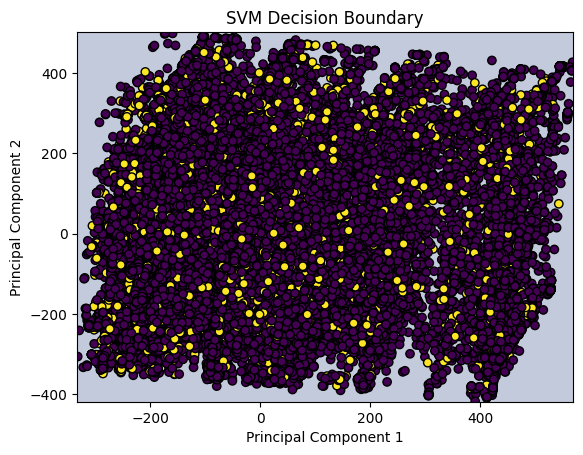

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  # Import pandas for type checking

def simple_decision_boundary(X, y, model, title):
    # Convert X to a NumPy array if it's a DataFrame
    if isinstance(X, pd.DataFrame):
        X = X.values  # Extract underlying NumPy array

    # Use PCA to reduce the dimensionality to 2 for visualization
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)

    x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
    y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Use the reduced dimensions for prediction
    Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, edgecolor='k')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

simple_decision_boundary(X_train, y_train, svm, 'SVM Decision Boundary')

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Train SVM
svm = SVC(kernel='rbf', C=1, gamma='scale')
svm.fit(X_train, y_train)

# Predictions
y_pred = svm.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18069
           1       0.00      0.00      0.00      2285

    accuracy                           0.89     20354
   macro avg       0.44      0.50      0.47     20354
weighted avg       0.79      0.89      0.83     20354



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1]:
!pip install ucimlrepo
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo
import pandas as pd

# fetch dataset
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)
df = diabetes_130_us_hospitals_for_years_1999_2008.data

# data (as pandas dataframes)
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets

##drop weight as it might skew with 98% gone
##drop tolazamide, miglitol, tolbutamide, glipizide-metformin
##troglitazone, acetohexamide, metformin-rosiglitazone,
##glimepiride-pioglitazone, metformin-pioglitazone, citoglipton
##examide as they showed up as super low feature importance
X = X.drop('weight', axis=1, errors='ignore')
columns_to_drop = [
    'tolazamide', 'miglitol', 'tolbutamide', 'glipizide-metformin',
    'troglitazone', 'acetohexamide', 'metformin-rosiglitazone',
    'glimepiride-pioglitazone', 'metformin-pioglitazone', 'citoglipton',
    'examide'
]

# Drop the columns
X = X.drop(columns=columns_to_drop, axis=1, errors='ignore')

##split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Training class distribution:")
print(pd.Series(y_train['readmitted']).value_counts(normalize=True))  # Access the 'readmitted' column
print("\nTest class distribution:")
print(pd.Series(y_test['readmitted']).value_counts(normalize=True))  # Access the 'readmitted' column

# Display the shape of the splits
print(f"\nTraining features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")

##convert y to binary, YES if <30, NO for any other
y_binary_train = ['NO' if (x == 'NO' or x == '>30') else 'YES' for x in y_train['readmitted']]
y_binary_test = ['NO' if (x == 'NO' or x == '>30') else 'YES' for x in y_test['readmitted']]
##then do 0 for all NOs, 1 for all YES(<30)
y_encoded_train = LabelEncoder().fit_transform(y_binary_train)
y_encoded_test = LabelEncoder().fit_transform(y_binary_test)


/usr/local/lib/python3.10/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


Training class distribution:
readmitted
NO     0.539122
>30    0.349285
<30    0.111593
Name: proportion, dtype: float64

Test class distribution:
readmitted
NO     0.539108
>30    0.349268
<30    0.111624
Name: proportion, dtype: float64

Training features shape: (81412, 35)
Test features shape: (20354, 35)


In [2]:
import numpy as np
def fit_label_encode(df_train):
    object_cols = df_train.select_dtypes(include=['object']).columns.tolist()
    encoders = {}  # To store LabelEncoders for each column

    for col in object_cols:
        le = LabelEncoder()
        # Handle unseen values by adding them to the encoder's classes_
        # This ensures all potential values are accounted for
        unique_values = df_train[col].astype(str).unique().tolist()
        le.classes_ = np.array(unique_values)
        # Fit the encoder on all unique values and then transform
        df_train[col] = le.fit_transform(df_train[col].astype(str))
        encoders[col] = le

    return df_train, encoders

def transform_label_encode(df_test, encoders):
    object_cols = df_test.select_dtypes(include=['object']).columns.tolist()

    for col in object_cols:
        if col in encoders:  # Check if encoder exists for the column
            le = encoders[col]
            # Handle unseen values during transform
            # Replace them with a special token or handle them appropriately
            df_test[col] = df_test[col].astype(str).map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)  # Replace unseen with -1 or a suitable strategy

        else:
            raise ValueError(f"Column {col} not present in the encoders from training data!")

    return df_test

# Example usage
X_train_encoded, encoders = fit_label_encode(X_train)
X_test_encoded = transform_label_encode(X_test, encoders)

In [3]:
from imblearn.over_sampling import SMOTE

# Create SMOTE object
smote = SMOTE(sampling_strategy='auto', random_state=42)  # 0.4 means 40% of the majority class size

# Fit and transform the training data
X_resampled, y_resampled = smote.fit_resample(X_train_encoded, y_encoded_train)

# Check the new class distribution
print("Resampled training class distribution:")
print(pd.Series(y_resampled).value_counts(normalize=True))

print("Training class distribution:")
print(pd.Series(y_encoded_train).value_counts(normalize=True))  # Pass the array directly
print("\nTest class distribution:")
print(pd.Series(y_encoded_test).value_counts(normalize=True))  # Pass the array directly

Resampled training class distribution:
0    0.5
1    0.5
Name: proportion, dtype: float64
Training class distribution:
0    0.888407
1    0.111593
Name: proportion, dtype: float64

Test class distribution:
0    0.888376
1    0.111624
Name: proportion, dtype: float64


In [4]:
from sklearn.preprocessing import StandardScaler

# Assuming X_train and X_test are the features for training and testing data
scaler = StandardScaler()

# Fit scaler on training data only
X_train_scaled = scaler.fit_transform(X_resampled)

# Transform the test data using the fitted scaler
X_test_scaled = scaler.transform(X_test_encoded)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_scaled_resampled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_encoded_pca = pca.transform(X_test_scaled)

In [6]:
##put this into a support vector machine
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Sample 1000 rows from the data
# Convert to DataFrame before sampling:
X_sampled_from = pd.DataFrame(X_train_scaled_resampled_pca).sample(n=1000, random_state=42)
# Reset index for correct alignment:
X_sampled_from = X_sampled_from.reset_index(drop=True)

#y_resampled needs to be in a df to be sampled.
y_sampled_from = pd.DataFrame(y_resampled).sample(n=1000, random_state=42)
# Reset index for correct alignment:
y_sampled_from = y_sampled_from.reset_index(drop=True)

# Train SVM
svm = SVC(kernel='linear', C=1)
svm.fit(X_sampled_from, y_sampled_from[0])

# Predictions
y_pred = svm.predict(X_test_scaled_encoded_pca)

# Evaluate
print(classification_report(y_encoded_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.48      0.63     18082
           1       0.11      0.51      0.18      2272

    accuracy                           0.49     20354
   macro avg       0.50      0.50      0.40     20354
weighted avg       0.80      0.49      0.58     20354



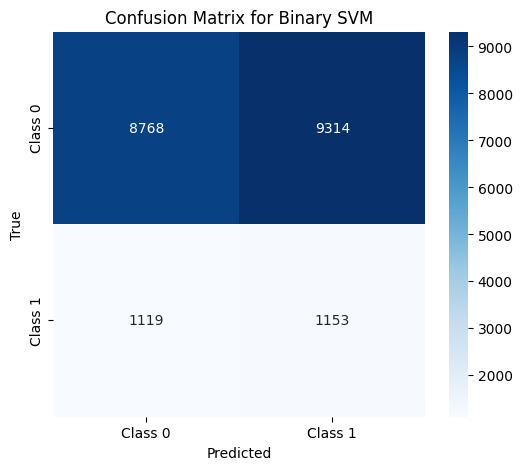

In [7]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_encoded_test, y_pred)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Binary SVM')
plt.show()

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import numpy as np

# Define the SVM model
svm = SVC()

# Define the parameter grid for random search
param_dist = {
    'C': np.logspace(-2, 3, 6),              # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],     # Kernel type
    'gamma': ['scale', 'auto'],              # Kernel coefficient
    'degree': [3, 4, 5],                     # Degree of the polynomial kernel
    'class_weight': [None, 'balanced']       # Class weights
}

# Create RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(svm, param_dist, n_iter=10, cv=5, n_jobs=-1, verbose=1, random_state=42)

# Sample 1000 rows from the data
# Convert to DataFrame before sampling:
X_sampled_from = pd.DataFrame(X_train_scaled_resampled_pca).sample(n=5000, random_state=42)
# Reset index for correct alignment:
X_sampled_from = X_sampled_from.reset_index(drop=True)

#y_resampled needs to be in a df to be sampled.
y_sampled_from = pd.DataFrame(y_resampled).sample(n=5000, random_state=42)
# Reset index for correct alignment:
y_sampled_from = y_sampled_from.reset_index(drop=True)


# Fit the model with random search
random_search.fit(X_sampled_from, y_sampled_from[0])

# Get the best parameters
print("Best parameters found: ", random_search.best_params_)

# Get the best estimator (model with best parameters)
best_model = random_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test_scaled_encoded_pca)

# Evaluate the model
from sklearn.metrics import classification_report
print(classification_report(y_encoded_test, y_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'class_weight': None, 'C': 1.0}
              precision    recall  f1-score   support

           0       0.89      0.40      0.55     18082
           1       0.11      0.61      0.19      2272

    accuracy                           0.42     20354
   macro avg       0.50      0.50      0.37     20354
weighted avg       0.80      0.42      0.51     20354



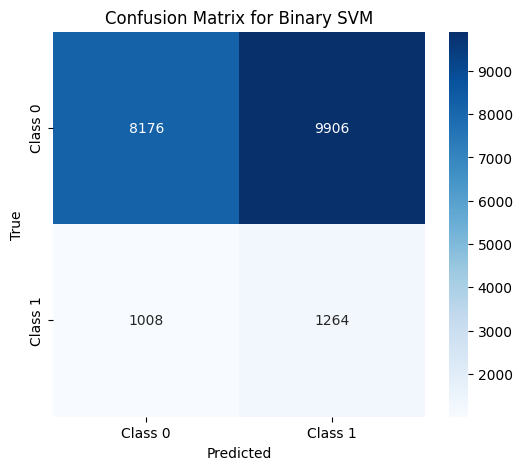

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_encoded_test, y_pred)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Binary SVM')
plt.show()

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the SVM model
svm = SVC()

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],                  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],     # Kernel type
    'gamma': ['scale', 'auto'],              # Kernel coefficient
    'degree': [3, 4, 5],                     # Degree of the polynomial kernel
    'class_weight': [None, 'balanced']       # Class weights
}

# Create GridSearchCV with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the model with grid search
grid_search.fit(X_sampled_from, y_sampled_from[0])

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the best estimator (model with best parameters)
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test_encoded)

# Evaluate the model
from sklearn.metrics import classification_report
print(classification_report(y_encoded_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      1.00      0.94     36164
           1       0.00      0.00      0.00      4543

    accuracy                           0.89     40707
   macro avg       0.44      0.50      0.47     40707
weighted avg       0.79      0.89      0.84     40707



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [44]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Example of oversampling the minority class using SMOTE
smote = SMOTE(random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train_encoded, y_encoded_train)

# Example of undersampling the majority class
undersample = RandomUnderSampler(random_state=42)
X_resampled_undersample, y_resampled_undersample = undersample.fit_resample(X_train_encoded, y_encoded_train)

from sklearn.preprocessing import StandardScaler

# Assuming X_train and X_test are the features for training and testing data
scaler = StandardScaler()

# Fit scaler on training data only
X_train_scaled_smote = scaler.fit_transform(X_resampled_smote)

# Transform the test data using the fitted scaler
X_test_scaled = scaler.transform(X_test_encoded)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_smote_scaled_resampled_pca = pca.fit_transform(X_train_scaled_smote)
X_test_scaled_encoded_pca = pca.transform(X_test_scaled)


In [39]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Step 2: Apply AdaBoost with the Decision Tree as the base learner
ada_boost = AdaBoostClassifier(n_estimators=50, random_state=42)

# Step 3: Fit AdaBoost model on the training data
ada_boost.fit(X_train_smote_scaled_resampled_pca, y_resampled_smote)

# Step 4: Make predictions
y_pred = ada_boost.predict(X_test_scaled_encoded_pca)

# Step 5: Evaluate the model
print("Accuracy Score: ", accuracy_score(y_encoded_test, y_pred))
print("Classification Report:\n", classification_report(y_encoded_test, y_pred))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:\n", confusion_matrix(y_encoded_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy Score:  0.48157610297730175
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.48      0.62     18082
           1       0.11      0.53      0.18      2272

    accuracy                           0.48     20354
   macro avg       0.50      0.50      0.40     20354
weighted avg       0.80      0.48      0.57     20354

Confusion Matrix:
 [[8609 9473]
 [1079 1193]]


In [41]:
from sklearn.preprocessing import StandardScaler

# Assuming X_train and X_test are the features for training and testing data
scaler = StandardScaler()

# Fit scaler on training data only
X_train_scaled_undersample = scaler.fit_transform(X_resampled_undersample)

# Transform the test data using the fitted scaler
X_test_scaled = scaler.transform(X_test_encoded)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_undersample_scaled_resampled_pca = pca.fit_transform(X_train_scaled_undersample)
X_test_scaled_encoded_pca = pca.transform(X_test_scaled)

In [42]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Step 2: Apply AdaBoost with the Decision Tree as the base learner
ada_boost = AdaBoostClassifier(n_estimators=50, random_state=42)

# Step 3: Fit AdaBoost model on the training data
ada_boost.fit(X_train_undersample_scaled_resampled_pca, y_resampled_undersample)

# Step 4: Make predictions
y_pred = ada_boost.predict(X_test_scaled_encoded_pca)

# Step 5: Evaluate the model
print("Accuracy Score: ", accuracy_score(y_encoded_test, y_pred))
print("Classification Report:\n", classification_report(y_encoded_test, y_pred))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:\n", confusion_matrix(y_encoded_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy Score:  0.4390783138449445
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.41      0.57     18082
           1       0.12      0.66      0.21      2272

    accuracy                           0.44     20354
   macro avg       0.52      0.54      0.39     20354
weighted avg       0.82      0.44      0.53     20354

Confusion Matrix:
 [[ 7433 10649]
 [  768  1504]]


In [46]:
from sklearn.ensemble import RandomForestClassifier
# Create a Random Forest classifier model
rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X_train_smote_scaled_resampled_pca, y_resampled_smote)

# Make predictions
y_pred = rf_model.predict(X_test_scaled_encoded_pca)

# Evaluate the model using a confusion matrix and classification report
conf_matrix = confusion_matrix(y_encoded_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_encoded_test, y_pred))

Confusion Matrix:
[[10552  7530]
 [ 1260  1012]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.58      0.71     18082
           1       0.12      0.45      0.19      2272

    accuracy                           0.57     20354
   macro avg       0.51      0.51      0.45     20354
weighted avg       0.81      0.57      0.65     20354



In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Example of oversampling the minority class using SMOTE
smote = SMOTE(random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train_encoded, y_encoded_train)


In [ ]:
import xgboost as xgb

# Apply XGBoost with class_weight or scale_pos_weight for imbalanced data
model = xgb.XGBClassifier(scale_pos_weight=ratio_of_classes, random_state=42)
model.fit(X_resampled, y_resampled)

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the SVM model
svm = SVC()

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],                  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],     # Kernel type
    'gamma': ['scale', 'auto'],              # Kernel coefficient
    'degree': [3, 4, 5],                     # Degree of the polynomial kernel
    'class_weight': [None, 'balanced']       # Class weights
}

# Create GridSearchCV with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the model with grid search
grid_search.fit(X_train_smote_scaled_resampled_pca, y_resampled_smote)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the best estimator (model with best parameters)
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test_scaled_encoded_pca)

# Evaluate the model
from sklearn.metrics import classification_report
print(classification_report(y_encoded_test, y_pred))

Fitting 5 folds for each of 144 candidates, totalling 720 fits


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the SVM model
svm = SVC()

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],                  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],     # Kernel type
    'gamma': ['scale', 'auto'],              # Kernel coefficient
    'degree': [3, 4, 5],                     # Degree of the polynomial kernel
    'class_weight': [None, 'balanced']       # Class weights
}

# Create GridSearchCV with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the model with grid search
grid_search.fit(X_resampled_undersample, y_resampled_undersample)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get the best estimator (model with best parameters)
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test_encoded)

# Evaluate the model
from sklearn.metrics import classification_report
print(classification_report(y_encoded_test, y_pred))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Initialize the Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
decision_tree.fit(X_train_smote_scaled_resampled_pca, y_resampled_smote)

# Make predictions on the test set
y_pred = decision_tree.predict(X_test_scaled_encoded_pca)

# Print the classification report to evaluate performance
print("Classification Report:")
print(classification_report(y_encoded_test, y_pred))

Confusion Matrix:
[[14833  3249]
 [ 1694   578]]


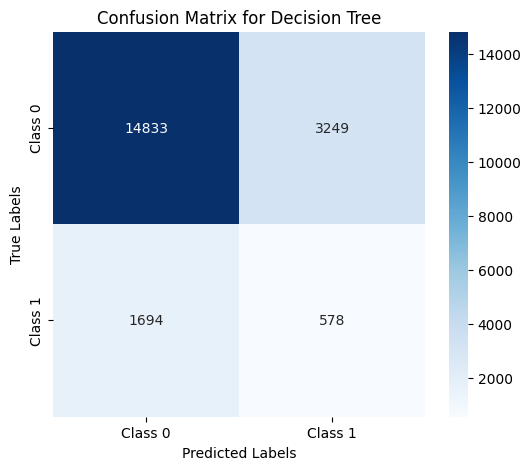

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train the decision tree model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_resampled_smote, y_resampled_smote)  # Replace with your actual train data

# Predict on the test data
y_pred = dt.predict(X_test_encoded)  # Replace with your actual test data

# Generate confusion matrix
cm = confusion_matrix(y_encoded_test, y_pred)  # Replace with your actual test labels

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Decision Tree")
plt.show()


In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Initialize the Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
decision_tree.fit(X_resampled_undersample, y_resampled_undersample)

# Make predictions on the test set
y_pred = decision_tree.predict(X_test_encoded)

# Print the classification report to evaluate performance
print("Classification Report:")
print(classification_report(y_encoded_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.55      0.68     18082
           1       0.13      0.54      0.21      2272

    accuracy                           0.55     20354
   macro avg       0.52      0.55      0.45     20354
weighted avg       0.82      0.55      0.63     20354



Confusion Matrix:
[[9928 8154]
 [1036 1236]]


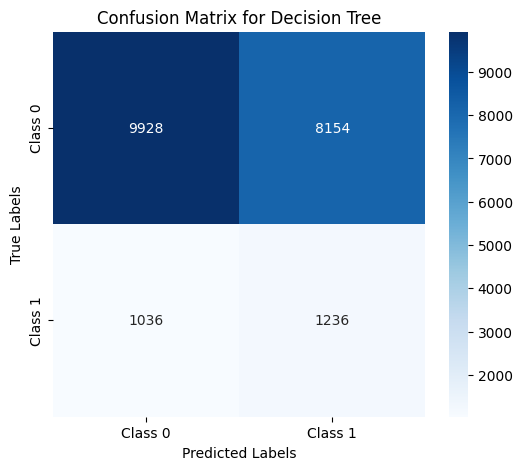

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train the decision tree model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_resampled_undersample, y_resampled_undersample)  # Replace with your actual train data

# Predict on the test data
y_pred = dt.predict(X_test_encoded)  # Replace with your actual test data

# Generate confusion matrix
cm = confusion_matrix(y_encoded_test, y_pred)  # Replace with your actual test labels

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Decision Tree")
plt.show()

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Train your Decision Tree model
dt = DecisionTreeClassifier(class_weight='balanced')
dt.fit(X_resampled_undersample, y_resampled_undersample)

# Get predicted probabilities for the positive class (class 1)
y_prob = dt.predict_proba(X_test_encoded)[:, 1]

# Adjust the threshold (e.g., set threshold to 0.3)
threshold = 0.01
y_pred_adjusted = (y_prob >= threshold).astype(int)

# Evaluate the model with the adjusted threshold
print("Confusion Matrix:")
print(confusion_matrix(y_encoded_test, y_pred_adjusted))
print("\nClassification Report:")
print(classification_report(y_encoded_test, y_pred_adjusted))

Confusion Matrix:
[[   56 18026]
 [    0  2272]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.01     18082
           1       0.11      1.00      0.20      2272

    accuracy                           0.11     20354
   macro avg       0.56      0.50      0.10     20354
weighted avg       0.90      0.11      0.03     20354



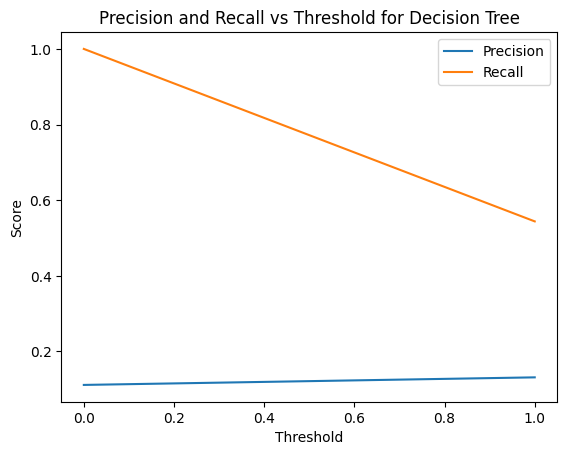

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Get precision-recall curve values
precision, recall, thresholds = precision_recall_curve(y_encoded_test, y_prob)

# Plot precision-recall curve
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold for Decision Tree')
plt.legend()
plt.show()
